In [1]:
%matplotlib inline
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
import collections
from collections import Counter
import seaborn as sns
#import pyfluidsynth
import random

from pathlib import Path
import pretty_midi
import librosa.display
import glob
import datetime

from music21 import *

# import tensorflow as tf
# tf.enable_eager_execution()

%load_ext autoreload
%autoreload 2

folder = 'train/'


In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

In [3]:
# some prep steps
# for google colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')
    data_folder = "/content/drive/My Drive/Colab Notebooks/data/"
    os.chdir(data_folder)
else:
    data_folder = ""


# A. Preprocess Midi file
#### Choose a harmony and a melody track from a MIDI file

In [4]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

def oneHot(idx, arraysize):
    if idx >= arraysize:
        print("error idx > arraysize")
        return
    ar = np.zeros(arraysize)
    ar[idx] = 1
    return ar

def multihot(li, size):
    result = np.zeros(size)
    result[li] = np.ones(len(li))
    return result

In [5]:
## PARAMS
# highest note is melody
LOW = 48 # C2=48, C3=60, C4=72, C5=84, C6=96
HIGH = 84 # range(48,84) = 36 notes 

# input sizes
MELODY = 37 
TIMES = 48
CHORDS = 12


In [6]:
# krumhansl schmuckler
# adapted from https://gist.github.com/bmcfee/1f66825cef2eb34c839b42dddbad49fd
import scipy.linalg
import scipy.stats

def ks_key(X, weights='kessler'):
    '''Estimate the key from a pitch class distribution
    
    Parameters
    ----------
    X : np.ndarray, shape=(12,)
        Pitch-class energy distribution.  Need not be normalized
        
    Returns
    -------
    major : np.ndarray, shape=(12,)
    minor : np.ndarray, shape=(12,)
    
        For each key (C:maj, ..., B:maj) and (C:min, ..., B:min),
        the correlation score for `X` against that key.
    '''
    X = scipy.stats.zscore(X)
    
    # Coefficients from Kumhansl and Schmuckler
    # as reported here: http://rnhart.net/articles/key-finding/
    
    # weights as https://musicinformationretrieval.wordpress.com/2017/02/24/state-of-the-art-2/
    if weights == 'kessler':
        major = np.asarray([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
        minor = np.asarray([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
    elif weights == 'schmuckler':
        major = np.asarray([6.35, 2.33, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
        minor = np.asarray([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
    elif weights == 'aarden':
        major = np.asarray([17.7661, 0.145624, 14.9265, 0.160186, 19.8049, 11.3587, 0.281248, 22.062, 0.145624, 8.15494, 0.232998, 4.95122])
        minor = np.asarray([18.2648, 0.737619, 14.0499, 16.8599, 0.702494, 14.4362, 0.702494, 18.6161, 4.56621, 1.93186, 7.37619, 1.75623])
    elif weights == 'sapp':
        major = np.asarray([2, 0, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1])
        minor = np.asarray([2, 0, 1, 1, 0, 1, 0, 2, 1, 0, 0.5, 0.5])
    elif weights == 'bellman':
        major = np.asarray([16.8, 0.86, 12.95, 1.41, 13.49, 11.93, 1.25, 20.28, 1.8, 8.04, 0.62, 10.57])
        minor = np.asarray([18.16, 0.69, 12.99, 13.34, 1.07, 11.15, 1.38, 21.07, 7.49, 1.53, 0.92, 10.21])
    elif weights == 'temperley':
        major = np.asarray([0.748, 0.06, 0.488, 0.082, 0.67, 0.46, 0.096, 0.715, 0.104, 0.366, 0.057, 0.4])
        minor = np.asarray([0.712, 0.84, 0.474, 0.618, 0.049, 0.46, 0.105, 0.747, 0.404, 0.067, 0.133, 0.33])
        
        
    major = scipy.stats.zscore(major)
    minor = scipy.stats.zscore(minor)
    
    # Generate all rotations of major
    major = scipy.linalg.circulant(major)
    minor = scipy.linalg.circulant(minor)
    
    major = major.T.dot(X)
    minor = minor.T.dot(X)
    
    major_max = np.argmax(major)
    minor_max = np.argmax(minor)
    return major_max if np.max(major) >= np.max(minor) else minor_max+12

In [7]:
# MIDI processing
def getTracks(file):
    pm_harmony = pretty_midi.PrettyMIDI(folder+'chords/'+file).instruments[0].notes
    pm_melody = pretty_midi.PrettyMIDI(folder+'melody/'+file).instruments[0].notes
    return {'melody': pm_melody, 'harmony': pm_harmony}

def getMelodyAndHarmonyBass(file):
    #already midi file with one piano and one melody
    pm = pretty_midi.PrettyMIDI(file)
    pm.remove_invalid_notes()
    for i, elt in enumerate(pm.instruments):
        if 'piano' in pm.instruments[i].name.lower():
            piano = pm.instruments[i].notes
        elif 'bass' in pm.instruments[i].name.lower():
            bass = pm.instruments[i].notes
    
    result = {'melody': bass, 'harmony': piano}
    return result


def getMelodyAndHarmony(file):
    def padAndAdd(a,b):
        return sorted(a+b, key= lambda x:x.start)
    
    pm = pretty_midi.PrettyMIDI(file)
    pm.remove_invalid_notes()
    print("\nEasy Processing: "+file)
    
    if len(pm.instruments) == 1:
        print("Both: Using only track for both harmony and melody")
        pianoroll = pm.instruments[0].notes
        return {'melody': pianoroll, 'harmony': pianoroll}
    
    else:
        maxlen = 0
        pianos = []
        guitars = []
        melodies = []
        for i, elt in enumerate(pm.instruments):
            #if pm.instruments[i].is_drum:
            #    continue
            pianoroll = pm.instruments[i].get_piano_roll().T
            numnotes = pianoroll.nonzero()[0].shape[0]
            if numnotes > maxlen:
                mostnotes = i
                maxlen = numnotes
            if 'piano' in pm.instruments[i].name.lower():             #if pm.instruments[i].program in range(8): # MIDI 0..7 are pianos
                pianos.append((pm.instruments[i].notes,numnotes))
            if 'guitar' in pm.instruments[i].name.lower():             #if pm.instruments[i].program in range(24,32):
                guitars.append((pm.instruments[i].notes,numnotes))
            if 'melody' in pm.instruments[i].name.lower():
                # melodies.append((pianoroll,numnotes)) do i really want to padandadd two melodies always??
                melodies.append(pm.instruments[i].notes)

        if pianos != []:
            print("Harmony: Using piano with most notes as harmony of", len(pianos))
            pianowithmostnotes = max(pianos, key=lambda x: x[1])
            harmonytrack = pianowithmostnotes[0]
        elif guitars != []:
            print("Harmony: Using guitar with most notes as harmony of", len(guitars))
            guitarwithmostnotes = max(guitars, key=lambda x: x[1])
            harmonytrack = guitarwithmostnotes[0]
        else:
            print("Error: no piano or guitar track found")
            harmonytrack = pm.instruments[0].notes
            return

        if len(melodies) == 1:
            print("Melody: using only melody track as melody")
            melodytrack = melodies[0]
        elif len(melodies) == 2:
            print("Melody: padding and adding two melodies to one")
            melodytrack = padAndAdd(melodies[0], melodies[1])
        elif len(melodies) > 2:
            print("Melody: more than 2 melody tracks. padding and adding first two of # ", len(melodies),"melodies.")
            melodytrack = padAndAdd(melodies[0], melodies[1])
        else:
            print("Error: no melody track found.")
            melodytrack = pm.instruments[0].notes
            return

        return {'melody': melodytrack, 'harmony': harmonytrack}

def processMidi(file):
    pm = pretty_midi.PrettyMIDI(folder+'chords/'+file)
    #tracks = getMelodyAndHarmony(file)
    #tracks = getMelodyAndHarmonyBass(file) //changing, this doesnt work anymore -> DACBass
    tracks = getTracks(file)

    pmnotes = tracks['melody']
    notes, times = [], []
    currenttime = 0
    for i, note in enumerate(pmnotes):
        if note.start > currenttime:
            notes.append(MELODY-1)
            duration = pm.time_to_tick(note.start - currenttime)
            times.append(duration)
        if note.pitch in range(LOW,HIGH):
            notes.append(note.pitch - LOW)
        else:
            notes.append(note.pitch % 12)
        if i < len(pmnotes)-1 and note.end > pmnotes[i+1].start: # overlap with next note
            times.append(pm.time_to_tick(pmnotes[i+1].start - note.start))
            currenttime = pmnotes[i+1].start
        else:
            times.append(pm.time_to_tick(note.end - note.start))
            currenttime = note.end
    times = np.array(np.round(np.array(times)/pm.resolution*12),dtype=np.int32)
    
#     getChords
    pmnotes = tracks['harmony']
    notesDict = {}
    for i, note in enumerate(pmnotes):
        startbeat = int(pm.time_to_tick(note.start)/pm.resolution)
        endbeat = int(pm.time_to_tick(note.end)/pm.resolution)
        if startbeat == endbeat:
            endbeat += 1
        for j in range(startbeat, endbeat): #evry beat
            notesDict[j] = notesDict.get(j,np.zeros(12)) + oneHot(note.pitch % 12,12)
    

    # append for every beat (timestep) a vector. either np.zeros or chordinfovector
    chords = []
    for i in range(max(notesDict)): 
        chords.append(notesDict.get(i,np.zeros(12)))
    chordsByBeat = np.array(chords)
    
    
    # connect notes and chords
    currbeat = 0
    newchords = []
    for time in times:
        beat = int(currbeat/12)
        newchord = np.zeros(12)
        
        for j in range(int(np.floor(time/12))+1): 
            if j + beat < chordsByBeat.shape[0]:
                newchord += chordsByBeat[j+beat]
        newchords.append(newchord)
        currbeat += time
    chords = np.array(newchords)
    
    # clip at higher than 1
    chords[np.where(chords > 1)] = np.ones(chords.shape)[np.where(chords > 1)]
    
    
    # cleanup
    times[np.where(times > 48)[0]] = 48
    notes = np.array(notes)[np.where(times > 0)[0]]
    chords = chords[np.where(times > 0)[0]]
    times = times[np.where(times > 0)[0]]
    times = times - 1 # reshift to 0..47
    
    # wrong:
    chordsroot = np.zeros(chords.shape)
    
    #new Chord and key analysis, first only key analysis
    algkey = ks_key(pm.get_pitch_class_histogram(), 'aarden')
    key = oneHot(algkey,24)
    
    return notes, times, chords, chordsroot, chordsByBeat, key

In [8]:
def processMXL(xfolder,file):
    score = converter.parse(xfolder+file)
    if len(score.parts)>1:
        print("Scoreparts", len(score.parts))
    
    currchord = None
    features = []
    for measure in score.parts[0].getElementsByClass('Measure'):
        for n in measure:
            if type(n) == harmony.ChordSymbol:
                currchord = n.orderedPitchClasses
                root = n.root().midi % 12
            if currchord == None:
                continue
            if type(n) == note.Note:
                currnote = int(n.pitch.midi - LOW)
                currdur = int(n.duration.quarterLength*12) - 1 # = /4*48 & 1 indiziert
                if currnote >= MELODY:
                    currnote = MELODY - 1
                if currdur >= TIMES:
                    currdur = TIMES - 1
                if currdur < 0:
                    continue
                features.append((currnote,currdur,root,currchord))
                
    
    # return features
    # later change feature format to default, now turn feature to separate lists
    # forgot about rests TODO
    notes = np.array([feature[0] for feature in features])
    times = np.array([feature[1] for feature in features])
    chordsroot = np.array([oneHot(feature[2],12) for feature in features])
    chords = np.array([multihot(feature[3],12) for feature in features])
    
    return notes,times,chords,chordsroot,_,_

In [9]:
def processMidi2(folder,file):
    score = converter.parse(folder+'melody/'+file)
    score2 = converter.parse(folder+'chords/'+file)
    if len(score.parts)>1:
        print("Scoreparts", len(score.parts))
    
    currchord = None
    features = []
    for measure in score.parts[0].getElementsByClass('Measure'):
        for n in measure:
            if type(n) == harmony.ChordSymbol:
                currchord = n.orderedPitchClasses
                root = n.root().midi % 12
            if currchord == None:
                continue
            if type(n) == note.Note:
                currnote = int(n.pitch.midi - LOW)
                currdur = int(n.duration.quarterLength*12) - 1 # = /4*48 & 1 indiziert
                if currnote >= MELODY:
                    currnote = MELODY - 1
                if currdur >= TIMES:
                    currdur = TIMES - 1
                if currdur < 0:
                    continue
                features.append((currnote,currdur,root,currchord))
                
    
    # return features
    # later change feature format to default, now turn feature to separate lists
    # forgot about rests TODO
    notes = np.array([feature[0] for feature in features])
    times = np.array([feature[1] for feature in features])
    chordsroot = np.array([oneHot(feature[2],12) for feature in features])
    chords = np.array([multihot(feature[3],12) for feature in features])
    
    return notes,times,chords,chordsroot,_,_

s = converter.parse(folder+'melody/014.mid')
list(s.parts[0])

ConverterException: File not found or no such format found for: train/melody/014.mid

In [15]:
# Input representation
def getCircleOfThirds(note):
    """input: note, scalar in [0,C)
    output: array, size (11,) including 3 bits for octave, 1 for rest
    """
    circleMajor = lambda x: x%4
    circleMinor = lambda x: x%3
    representation = np.zeros(11)
    if note < MELODY-1:
        absnote = note % 12
        octave = int(note/12)
        representation[7+octave] = 1
        representation[circleMajor(absnote)] = 1
        representation[4+circleMinor(absnote)] = 1
    else:
        representation[-1] = 1
    return representation

def getDuration(duration):
    """input size (1,) in [0,48)
       output size (6,)
    """
    return np.unpackbits(np.uint8(duration))[2:]

def getChord(chord):
    """input size (12,)
    outputs current and next chord shape (7,)
    """
    repre = np.zeros(7)
    for i, elt in enumerate(chord):
        x = elt * getCircleOfThirds(i)[:7]
        repre += x
    return repre

def getFeatureVectors(processedMidi, modulation=False):
    """input size [7(pitch)+2(octaves)+1(Rest)]+6(duration)+7(chords)+7(nextchords)=30=Fsize #TODO: maybe change chords
    Creates Feature Vector from notes lists.
    Input: notes, times, chords from processMIDI
    Output: features array, size: (N, Fsize)  Fsize varies
    """
    notes, times, chords, chordsroot, chordsByBeat, key = processedMidi
    features = []
    for i, note in enumerate(notes[:-1]):
        feature = np.empty(0)
        if encodingDict['melody']:
            if notes[i] < MELODY: # pitch or pause bit
                feature = np.concatenate((feature, oneHot(notes[i],MELODY)))
            else:
                print("melody over 37")
                feature = np.concatenate((feature, np.zeros(MELODY)))
            
        if encodingDict['melodyModulo']: 
            if notes[i] < MELODY-1: # only pitch bit or zeros if pause
                feature = np.concatenate((feature, oneHot(notes[i]%12,12)))
            else:
                feature = np.concatenate((feature, np.zeros(12)))
        if encodingDict['melodyEncoded']: # pitch+octave+rest
            feature = np.concatenate((feature,getCircleOfThirds(note)))
        if encodingDict['duration']:
            feature = np.concatenate((feature,oneHot(int(times[i]),48)))  
        if encodingDict['durationEncoded']:
            feature = np.concatenate((feature,getDuration(times[i])))
        if encodingDict['chordsRoot']:
            feature = np.concatenate((feature,chordsroot[i]))
            feature = np.concatenate((feature,chordsroot[i+1]))
        if encodingDict['chordsNormally']:
            feature = np.concatenate((feature,chords[i]))
            feature = np.concatenate((feature,chords[i+1]))
        if encodingDict['chordsEncoded']:
            feature = np.concatenate((feature,getChord(chords[i])))  # chord ERROR: MAKE THIS BETTER
            feature = np.concatenate((feature,getChord(chords[i+1])))   # chord ERROR: MAKE THIS BETTER
        if encodingDict['key']:
            feature = np.concatenate((feature,key))
        features.append(feature)
    features = np.array(features)
    return features.astype('float32')

def getInputSequences(processedMidi, padding=False, seq_len=16):
    """Create Net Input.
    Input: features from getFeatureVectors or getEncodedFeatureVectors
    Output: 
        - Sequences, size: (157, seq_len)
        - Labels, one-hot, size: (MELODY,)
    """
    features = getFeatureVectors(processedMidi)
    notes, times, _, _, _, _ = processedMidi
    sequences = []
    labels = []
    i = 0
    if padding == True:
        padded_notes = np.concatenate((np.zeros((seq_len,features.shape[1])),features[:seq_len]))
        for j in range(seq_len):
            sequences.append(padded_notes[j:j+seq_len])
            label_pitch = notes[j]
            label_duration = times[j]
            labels.append((label_pitch, label_duration))
    while i+seq_len < features.shape[0]:
        sequences.append(features[i:i+seq_len])
        label_pitch = notes[i+seq_len]
        label_duration = times[i+seq_len]
        labels.append((label_pitch, label_duration))
        i += 1     # or += seq_len
        
    sequences = np.array(sequences)
    labels = np.array(labels)
    return sequences, labels

def modulate(processedMidi, modulate=0):
    """modulates downwards"""
    notes, times, chords, chordsroot, chordsByBeat, key = processedMidi
    i = modulate
    modnotes = notes - i
    modnotes[np.where(modnotes == 36 - i)[0]] = 36
    modnotes[np.where(modnotes < 0)[0]] += 12 # experiment

    modchordsroot = np.append(chordsroot[:,i:],chordsroot[:,:i],axis=1)
    modchords = np.append(chords[:,i:],chords[:,:i],axis=1)

    modcbb = chordsByBeat
#     if chordsByBeat is not None:
#         modcbb = np.append(chordsByBeat[:,i:],chordsByBeat[:,:i],axis=1)
#     else:
#         modcbb = None


    processedMidi = modnotes, times, modchords, modchordsroot, modcbb, key
    return processedMidi

In [10]:
# Choose encoding and load files
encodingDict = {
    'melody': True,
    'melodyModulo': True,
    'melodyEncoded': False,
    'duration': False,
    'durationEncoded': False,
    'chordsRoot': True,
    'chordsNormally': True,
    'chordsEncoded': False,
    'key': False
}

# X. Expanded Dataset

In [11]:
# schdrauf! wikifonia!
# exfolder = 'lmd_full/0/'
# exfiles = [file for file in os.listdir(exfolder)]
# #for file in exfiles:
    
# exfiles[0]

# Y. XML Dataset

In [12]:
# plan: go through piece measure by measure. if measure consists of no notes skip it. if measure consists of no chords take chord from before.
# for each measure: collect notes and durations. what with overlapping notes? just store with longer duration
# and collect chords, one for each beat.
# maybe i can skip offset for chords and notes matchin because streams are sorted?
# TODO: tied notes are separated

In [13]:
xfolder = 'datasets/Wikifonia/'
xfiles = [file for file in os.listdir(xfolder)]
x = xfolder+xfiles[0]
score = converter.parse(x)
score.analyze('key')

<music21.key.Key of E- major>

In [16]:
modulation = True
t=time.time()
# 100 = 73s => 1000 = 12min => 6000 = 72min
for i, file in enumerate(xfiles[:10]):
#     print(i, file)
    processed = processMXL(xfolder,file)
    if processed[0].size == 0:
        continue
    if modulation == True:
        for mod_i in range(12): # modulate
            processed = modulate(processed, modulate = mod_i)
            sequences, labels = getInputSequences(processed, padding=False, seq_len=8)
            if labels.shape[0]>0:
                X = sequences if i==0 else np.concatenate((X, sequences))
                y = labels if i==0 else np.concatenate((y, labels))
    else:
        sequences, labels = getInputSequences(processed, padding=False, seq_len=8)
        if labels.shape[0] > 0:
            X = sequences if i==0 else np.concatenate((X, sequences))
            y = labels if i==0 else np.concatenate((y, labels))

X.shape, y.shape, "elapsedtime "+str(int(time.time()-t))+"s"

((18235, 8, 97), (18235, 2), 'elapsedtime 14s')

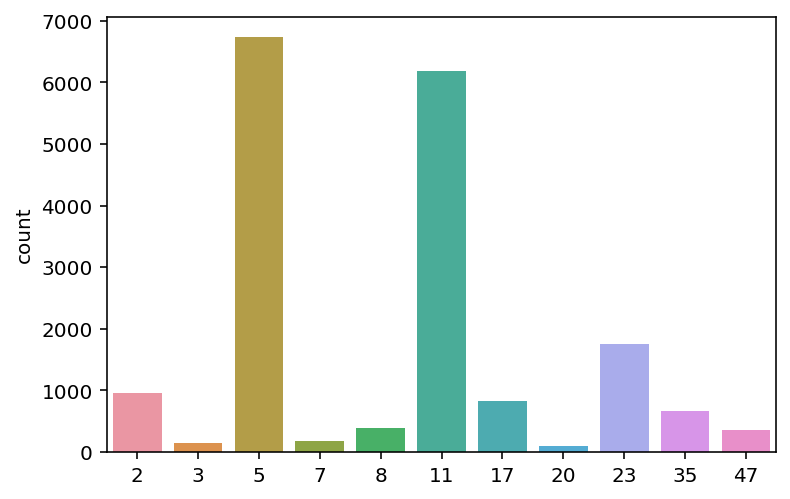

In [17]:
# stats of training data
pitches = y[:,0]
durations = y[:,1]
sns.countplot(durations)

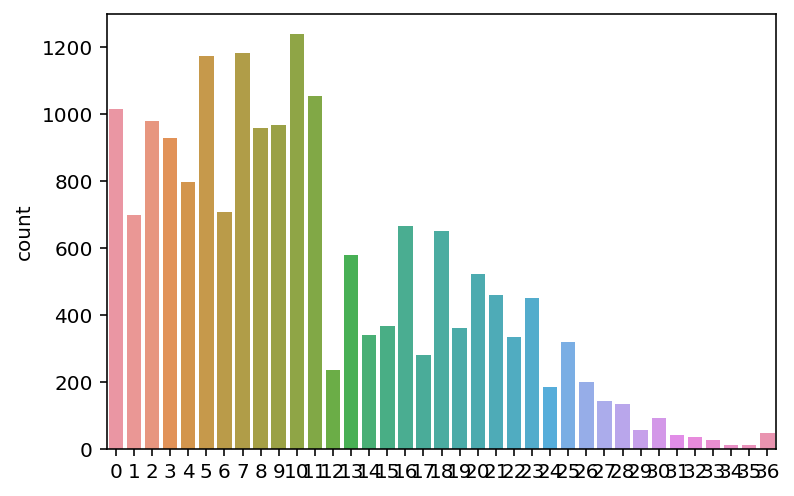

In [18]:
sns.countplot(pitches)

# B. Load Data

In [19]:
# gets all .mid filenames from folder train/ in one line
folder = 'datasets/trainData/'
files = [file for file in os.listdir(folder+'chords')]
files[:4]

['014.mid', '028.mid', '029.mid', '015.mid']

In [20]:
# min and max note
min([note.pitch for file in files for note in pretty_midi.PrettyMIDI(folder+'melody/'+file).instruments[0].notes]),\
max([note.pitch for file in files for note in pretty_midi.PrettyMIDI(folder+'melody/'+file).instruments[0].notes]),\


(60, 83)

In [0]:
# proc = processMidi(files[0])
# a,b = getInputSequences(proc, padding=False, seq_len=8)
# a[0]

In [0]:
modulation = True

for i, file in enumerate(files):
#     print(i, file)
    processedMidi = processMXL(folder+'melody/',file)
#     processedMidi = processMidi(file)
    if modulation == True:
        for mod_i in range(12): # modulate
            processedMidi = modulate(processedMidi, modulate = mod_i)
            sequences, labels = getInputSequences(processedMidi, padding=False, seq_len=8)
            if labels.shape[0]>0:
                X = sequences if i==0 else np.concatenate((X, sequences))
                y = labels if i==0 else np.concatenate((y, labels))
    else:
        sequences, labels = getInputSequences(processedMidi, padding=False, seq_len=8)
        if labels.shape[0] > 0:
            X = sequences if i==0 else np.concatenate((X, sequences))
            y = labels if i==0 else np.concatenate((y, labels))

X.shape, y.shape

0
(array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0.], dtype=float32))
[]


IndexError: too many indices for array

In [0]:
def writeMidiSample(notes, times, file, originalfile, tempo=120, resolution=12):
    pm = pretty_midi.PrettyMIDI(resolution=resolution, initial_tempo=tempo)
    pminst = pretty_midi.Instrument(program=0)
    currtime = 0
    for i, note in enumerate(notes):
        if note != MELODY-1:
            pitch = note+LOW
            start = pm.tick_to_time(int(currtime))
            end = pm.tick_to_time(int(currtime+times[i]))
            if end > start:
                pmnote = pretty_midi.Note(velocity=100, pitch = pitch, start=start, end=end)
                pminst.notes.append(pmnote)
        currtime += times[i]+1
    pm.instruments.append(pminst)

    pm.write(file)
    return pm

[36, 33, 36, 33, 36, 33, 36, 33, 36]
[14, 9, 13, 9, 12, 9, 17, 9, 11]


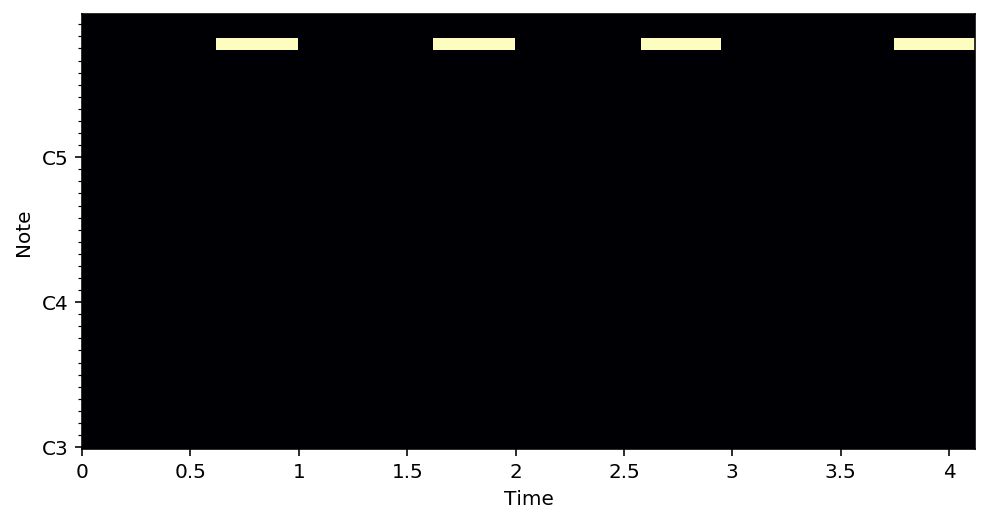

In [0]:
rand = random.randint(1,101)
sample, samplelabel = X[rand], y[rand]


notes, times = [], []
for i in range(sample.shape[0]):
    notes.append(np.argmax(sample[i,:MELODY]))
    times.append(np.argmax(sample[i,MELODY:MELODY+TIMES]))
notes.append(samplelabel[0])
times.append(samplelabel[1])



#look at a sample
pm = writeMidiSample(notes, times, 'old_notebooks/treval/lookatsample.mid', file)
plt.figure(figsize=(8, 4))
plot_piano_roll(pm, LOW, HIGH)
print(notes)
print(times)
display(IPython.display.Audio(pm.synthesize(fs=44000), rate=44000))

In [0]:
#np.save('Xbig.npy',X)
#np.save('ybig.npy',y)

# just load

In [96]:
# X = np.load('Xbig.npy')
# y = np.load('ybig.npy')

'1.14.0'

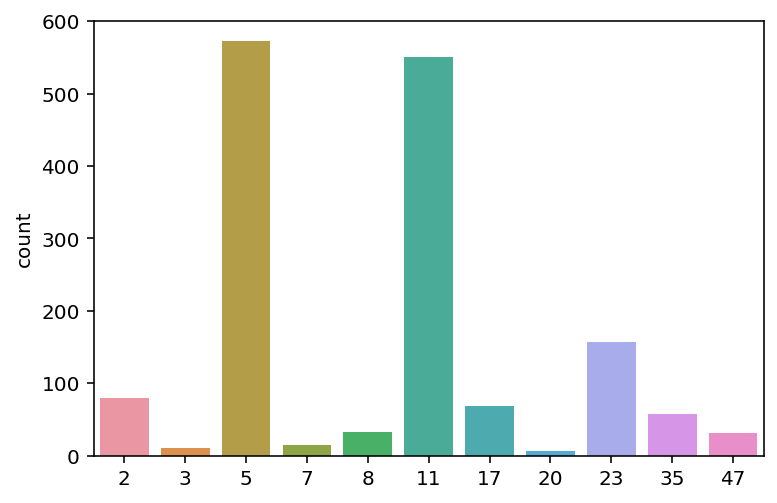

In [0]:
# stats of training data
pitches = y[:,0]
durations = y[:,1]
sns.countplot(durations)

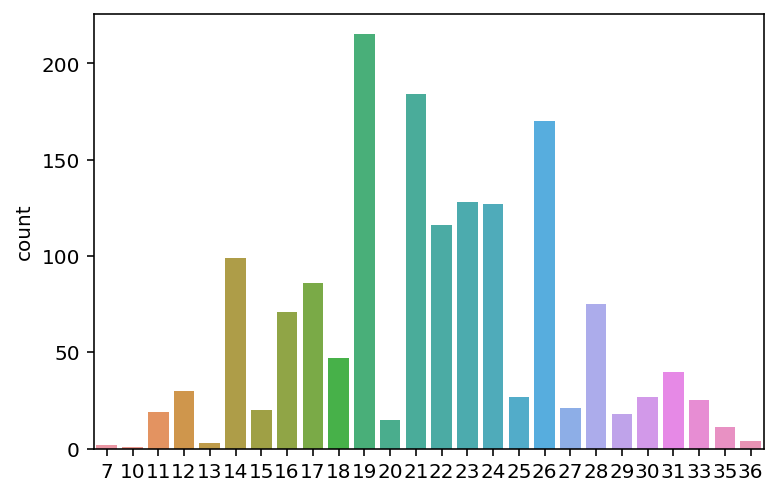

In [0]:
sns.countplot(pitches)

In [21]:
# train/val split
n = 500000
n = min(n,X.shape[0])
m = int(0.9*n)
data = X[:m]
labels = y[:m]
test_data = X[m:n]
test_labels = y[m:n]

perm = np.random.permutation(m)
p = int(0.9*m)

train_data = data[perm[:p]]
train_labels = labels[perm[:p]]
val_data = data[perm[p:]]
val_labels = labels[perm[p:]]

train_data.shape, train_labels.shape

((14769, 8, 97), (14769, 2))

### Load Data for Tensorflow

In [22]:
# ToDo
# weighted randomsampler!
# batchnormalization

# C. Train a model

In [0]:
def build(input_dim, seq_len, hidden_dim, num_layers, output_dim_pitch, output_dim_duration, cudnn):
    if cudnn:
        LSTM = tf.keras.layers.CuDNNLSTM(hidden_dim, 
                                    return_sequences=True, 
                                    return_state=False, 
                                    recurrent_initializer='glorot_uniform')
        lastlstm = tf.keras.layers.CuDNNLSTM(hidden_dim, 
                                    return_sequences=False, 
                                    return_state=False, 
                                    recurrent_initializer='glorot_uniform')
    else:
        LSTM = tf.keras.layers.LSTM(hidden_dim, 
                               return_sequences=True, 
                               return_state=False, 
                               activation='tanh',
                               recurrent_dropout=0,
                               unroll=False,
                               use_bias=True,
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')
        lastlstm = tf.keras.layers.LSTM(hidden_dim, 
                               return_sequences=False, 
                               return_state=False, 
                               activation='tanh',
                               recurrent_dropout=0,
                               unroll=False,
                               use_bias=True,
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')
    
        
    inputs = tf.keras.Input(shape=(seq_len, input_dim))
    x = inputs
    for i in range(num_layers-1):
        x = LSTM(x)
    x = lastlstm(x)
    x = tf.keras.layers.Dropout(rate=0.3)(x)
    pitch = tf.keras.layers.Dense(output_dim_pitch, activation='softmax', name='pitch_out')(x)
#     duration = tf.keras.layers.Dense(output_dim_duration, activation='softmax', name='duration_out')(x)

    model = tf.keras.Model(inputs=inputs, outputs=pitch)
    return model
    

In [0]:
# Build Model
model_params = {
    'input_dim': train_data.shape[-1],
    'seq_len': None,
    'hidden_dim': 128,
    'num_layers': 2,
    'output_dim_pitch': MELODY,
    'output_dim_duration': TIMES,
#     'cudnn': tf.test.is_gpu_available()
    'cudnn': False
}

model = build(**model_params)

In [0]:
# tf.keras.utils.plot_model(model, show_shapes=True)
# model_params_dep = {
#     'input_dim': train_data.shape[-1],
#     'seq_len': None,
#     'hidden_dim': 128,
#     'num_layers': 2,
#     'output_dim_pitch': MELODY,
#     'output_dim_duration': TIMES,
#     'cudnn': False
# }

# modeldep = build(**model_params_dep)
# modeldep.compile(
#     optimizer='adam',
#     loss={'pitch_out': 'sparse_categorical_crossentropy'},
#     metrics={'pitch_out': 'acc'})

In [0]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# #checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
def plot():
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [0]:
model.compile(
    optimizer='adam',
    loss={'pitch_out': 'sparse_categorical_crossentropy'},
    metrics={'pitch_out': 'acc'})

es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=5)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

Train on 104749 samples, validate on 11639 samples
Epoch 1/30
104704/104749 [============================>.] - ETA: 0s - loss: 1.8426 - acc: 0.3768
Epoch 00001: val_acc improved from 0.38165 to 0.39127, saving model to best_model.h5
104749/104749 [==============================] - 41s 387us/sample - loss: 1.8426 - acc: 0.3768 - val_loss: 1.7758 - val_acc: 0.3913
Epoch 2/30
104672/104749 [============================>.] - ETA: 0s - loss: 1.7406 - acc: 0.4075
Epoch 00002: val_acc improved from 0.39127 to 0.42409, saving model to best_model.h5
104749/104749 [==============================] - 40s 384us/sample - loss: 1.7407 - acc: 0.4075 - val_loss: 1.6950 - val_acc: 0.4241
Epoch 3/30
104640/104749 [============================>.] - ETA: 0s - loss: 1.6463 - acc: 0.4407
Epoch 00003: val_acc improved from 0.42409 to 0.44471, saving model to best_model.h5
104749/104749 [==============================] - 38s 365us/sample - loss: 1.6463 - acc: 0.4407 - val_loss: 1.6421 - val_acc: 0.4447
Epoch 4

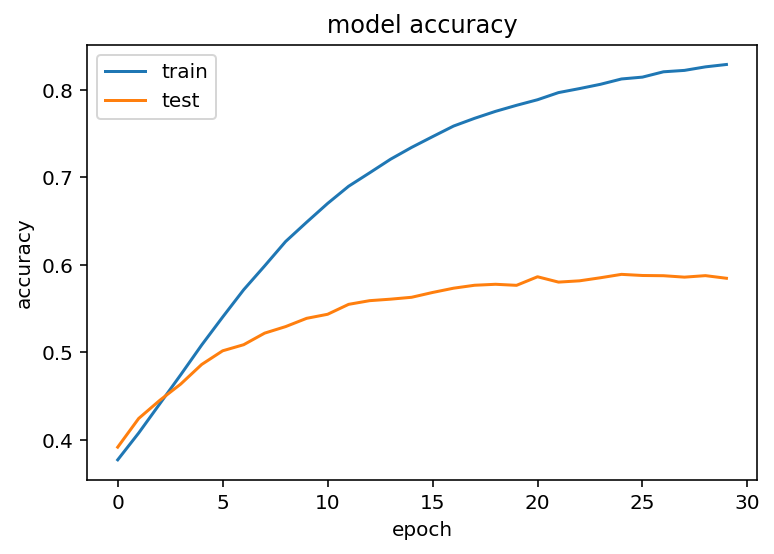

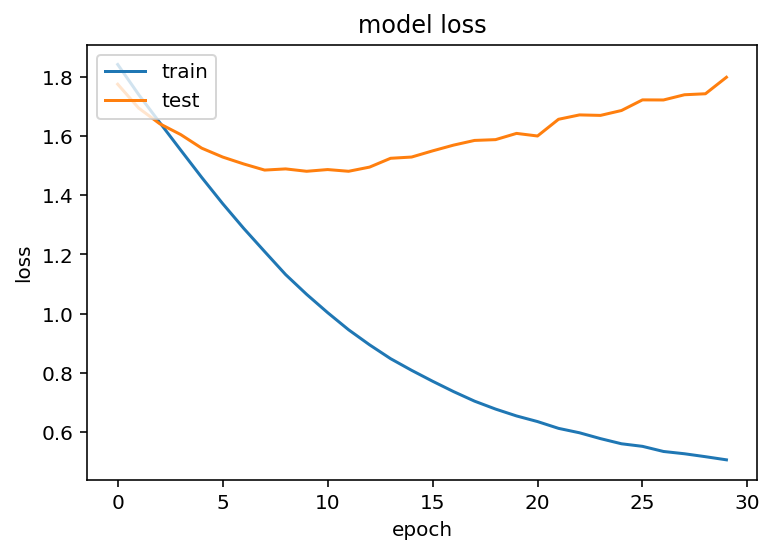

In [27]:
history = model.fit(train_data, train_labels[:,0], validation_split=0.1, batch_size=32, epochs=30, callbacks=[es,mc])
plot()

In [28]:
model.evaluate(val_data,val_labels[:,0])

12932/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.7294818958998686, 0.58884937]

In [29]:
model.evaluate(test_data,test_labels[:,0])

14369/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[3.2338977975087553, 0.33794975]

In [0]:

model.save('best_model2.h5')

({'pv': 0.438,
  'ts': 0.0,
  'cpr': 0.204,
  'rm3': 0.951,
  'rm4': 0.763,
  'rm5': 0.465,
  'rm6': 0.228,
  'pf': 0.0,
  'hc': (0.945, 0, 1824)},
 {20: 75,
  19: 119,
  13: 173,
  15: 179,
  18: 153,
  21: 99,
  11: 462,
  12: 91,
  17: 153,
  10: 567,
  22: 54,
  24: 31,
  26: 9,
  16: 188,
  8: 356,
  3: 534,
  1: 287,
  23: 29,
  14: 180,
  27: 2,
  25: 9,
  9: 651,
  4: 352,
  6: 317,
  7: 480,
  2: 594,
  0: 513,
  5: 532,
  36: 1,
  28: 1},
 <matplotlib.axes._subplots.AxesSubplot at 0x143ef3a58>)

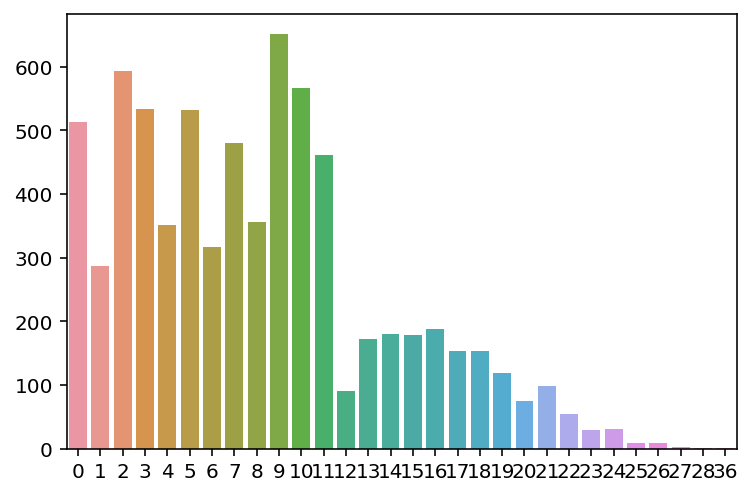

In [0]:
scores, c = getEvalScores(test_data)
scores, c, sns.barplot(np.array(list(c.keys())),np.array(list(c.values())))

In [0]:
# Evaluation
# create 20000 2-bar sequences with randomly chosen prime from (train, ne) test data (test data vllt zu wenig)

({'pv': 0.284,
  'ts': 0.0,
  'cpr': 0.356,
  'rm3': 0.631,
  'rm4': 0.372,
  'rm5': 0.306,
  'rm6': 0.242,
  'pf': 0.0,
  'hc': (0.5, 0, 6)},
 {24: 1, 22: 4, 19: 6, 15: 6, 20: 6, 17: 6},
 <matplotlib.axes._subplots.AxesSubplot at 0x13cd09860>)

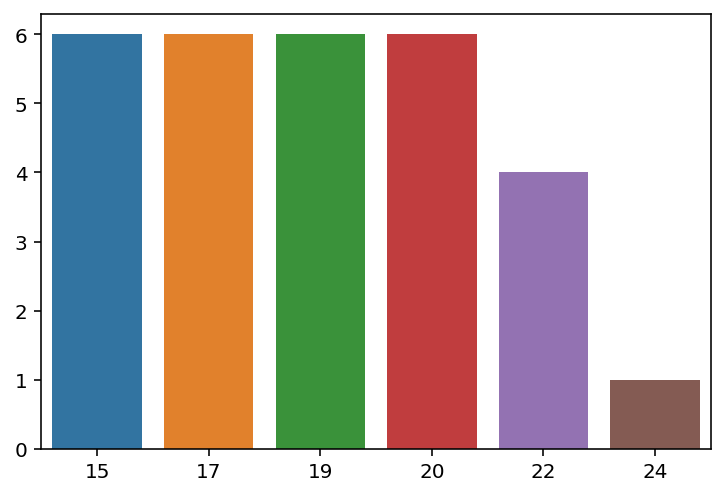

In [0]:
def getChordsFromFeaturevec(featurevec):
    indx = encodingDict['melody']*MELODY + encodingDict['melodyModulo']*12 + encodingDict['duration']*TIMES
    return featurevec[-1,indx:indx+12], featurevec[-1,indx+12:indx+24]


def getNoteScore(note, featurevec):
    note = note % 12
    chords = getChordsFromFeaturevec(featurevec)
    currchord = chords[0]
    nextchord = chords[1]
    return int(currchord[note]), int(nextchord[note])


def getScaleForChord(chord):
    # rotate to C chord and remember steps
    # then return scale for C chord and rotate back
    
    # major scale
    c_maj = np.array([1,0,0,0,1,0,0,1,0,0,0,0])
    c_7 = np.array([1,0,0,0,1,0,0,1,0,0,1,0])
    # c_6 = np.array([1,0,0,0,1,0,0,1,0,1,0,0]) # c_6 == c_min7
    c_maj7 = np.array([1,0,0,0,1,0,0,1,0,0,0,1])

    # minor scale
    c_min = np.array([1,0,0,1,0,0,0,1,0,0,0,0])
    c_min7 = np.array([1,0,0,1,0,0,0,1,0,0,1,0])
    c_dim = np.array([1,0,0,1,0,0,1,0,0,0,0,0])

    c_maj_scale = np.array([1,0,1,0,1,1,0,1,0,1,0,1])
    c_min_scale = np.array([1,0,1,1,0,1,0,1,1,0,1,0])

    idx, ch = -1, -1
    
    for i in range(12):
        if (chord == c_maj).all() or (chord == c_7).all() or (chord == c_maj7).all():
            idx = i
            scale = np.append(c_maj_scale[-i:], c_maj_scale[:-i])
            return scale
        elif (chord == c_min).all() or (chord == c_min7).all():
            idx = i
            scale = np.append(c_min_scale[-i:], c_min_scale[:-i])
            return scale
        elif (chord == c_dim).all():
            idx = i
            scale = np.append(c_min_scale[-i:], c_min_scale[:-i]) # dim scale?
            return scale
            
        chord = np.append(chord[1:],chord[0])
        
    return np.zeros(12)
        
def getScaleScore(note, featurevec):
    note = note % 12
    currchord, nextchord = getChordsFromFeaturevec(featurevec)
    cscale = getScaleForChord(currchord)
    nscale = getScaleForChord(nextchord)
    return cscale[note], nscale[note]

# Evaluation
def getHCScore(data):
    pauses = 0
    currchordscore = 0
    nextchordscore = 0
    currscalescore = 0
    nextscalescore = 0
    totalscore = 0

    for i, featurevec in enumerate(data):
        pred = model.predict(np.expand_dims(featurevec,0))
        note = np.argmax(pred)
    #     note = test_labels[i][0]

        if note == MELODY-1:
            pauses += 1

        else:
            cscore, nscore = getNoteScore(note,featurevec)
            cscale, nscale = getScaleScore(note, featurevec)

            if cscore > 0:
                currchordscore += cscore
            elif cscale > 0:
                currscalescore += cscale
            elif nscore > 0:
                nextchordscore += nscore
            elif nscale > 0:
                nextscalescore += nscale
            else:
        #         print(i, '\n', getChordsFromFeaturevec(featurevec), '\n', note % 12, note)
                pass

            totalscore += max(cscore, nscore, cscale, nscale)


    # currchordscore, nextchordscore, currscalescore, nextscalescore, totalscore, test_data.shape[0]
    return np.round((totalscore+pauses)/data.shape[0],3), pauses, data.shape[0]
# getHCScore(test_data)

def getEvalPred(sample):
    pred = np.argmax(model.predict(np.expand_dims(sample,0)))
    note = oneHot(pred,MELODY)
    notemod = oneHot(pred%12,12) if pred < MELODY - 1 else np.zeros(12)
    chord = sample[-1,-12:] # next chord from last note
    chordn = sample[0,-24:-12] # first chord is next chord
    newfeat = np.append(note, np.append(notemod, np.append(chord, chordn)))
    newsample = np.append(sample, np.expand_dims(newfeat,0),axis=0)
    for i in range(8):
        pred = np.argmax(model.predict(np.expand_dims(newsample,0)))
        note = oneHot(pred,MELODY)
        notemod = oneHot(pred%12,12) if pred < MELODY - 1 else np.zeros(12)
        chord = sample[i,-24:]
        newfeat = np.append(note, np.append(notemod, chord))
        newsample = np.append(newsample, np.expand_dims(newfeat,0),axis=0)
    return newsample[8:]


# consecutive pitch repetitions
def getCPR2(evalpred):
    c = 0
    m = evalpred.shape[0]-2
    for i in range(m):
        note = np.argmax(evalpred[i,:37])
        nextnote = np.argmax(evalpred[i+1,:37])
        nextnextnote = np.argmax(evalpred[i+2,:37])
        # print(note, nextnote)
        if note == nextnote and nextnote == nextnextnote:
            c += 1
    return c/m

# Tone Spans greater than octave
def getTS(evalpred):
    c = 0
    m = evalpred.shape[0]-1
    for i in range(m):
        note = np.argmax(evalpred[i,:37])
        nextnote = np.argmax(evalpred[i+1,:37])
        if note < nextnote - 12 or note > nextnote + 12:
            c += 1
    return c/m


# pitch variations: ratio distinct pitches vs number of notes
def getPV(evalpred):
    c = {}
    m = evalpred.shape[0]
    for i in range(m):
        note = np.argmax(evalpred[i,:37])
        c[note] = 1
    return len(c)/m, c

def getCorpus(data):
    # get all seqs and then unique
    corpus = []
    for d in data:
        m = d.shape[0]
        notes = []
        for i in range(m):
            note = np.argmax(d[i,:37])
            notes.append(note)
        corpus.append(notes)
        corpus = [list(x) for x in set(tuple(x) for x in corpus)]
    return corpus

def getSlicedCorpus(data, slices):
    m = data[0].shape[0]
    if slices > m:
        return "ERROR slices bigger than data dim"
    corpus = getCorpus(data)
    slicedcorpus = []
    for seq in corpus:
        for i in range(m-slices):
            slicedcorpus.append(seq[i:i+slices])
    slicedcorpus = [list(x) for x in set(tuple(x) for x in slicedcorpus)]
    return slicedcorpus

# rote memorization frequencies: copy seq of length 3 to 6
def getRM(evalpred,corpus):
    copyratio = [0,0]
    m = evalpred.shape[0]
    notes = []
    for i in range(m):
        note = np.argmax(evalpred[i,:37])
        notes.append(note)
    slices = len(corpus[0])
    if slices > m:
        return "ERROR slices bigger than data dim"
    for i in range(m-slices):
        if notes[i:i+slices] in corpus: # how cool is python?
            copyratio[0] += 1
        copyratio[1] += 1
    return copyratio[0]/copyratio[1]

# pause frequencies
def getPF(evalpred):
    ratio = [0,0]
    m = evalpred.shape[0]
    for i in range(m):
        note = np.argmax(evalpred[i,:37])
        if note == 36:
            ratio[0] += 1
        ratio[1] += 1
    return ratio[0]/ratio[1]


def getEvalScores(data):
    c = {}
    scores = {}
    corpus3 = getSlicedCorpus(train_data,3)
    corpus4 = getSlicedCorpus(train_data,4)
    corpus5 = getSlicedCorpus(train_data,5)
    corpus6 = getSlicedCorpus(train_data,6)
    for d in data:
        sample = getEvalPred(d)
        pv = getPV(sample)
        scores['pv'] = scores.get('pv',0) + pv[0]
        scores['ts'] = scores.get('ts',0) + getTS(sample)
        scores['cpr'] = scores.get('cpr',0) + getCPR2(sample)
        scores['rm3'] = scores.get('rm3',0) + getRM(sample,corpus3)
        scores['rm4'] = scores.get('rm4',0) + getRM(sample,corpus4)
        scores['rm5'] = scores.get('rm5',0) + getRM(sample,corpus5)
        scores['rm6'] = scores.get('rm6',0) + getRM(sample,corpus6)
        scores['pf'] = scores.get('pf',0) + getPF(sample)
        
        for key in pv[1]:
            c[key] = c.get(key,0) + pv[1][key]
        
    for entry in scores:
        scores[entry] = np.round(scores[entry]/data.shape[0],3)
        
    scores['hc'] = getHCScore(data)
    return scores, c
    
scores,c  = getEvalScores(test_data)
scores, c, sns.barplot(np.array(list(c.keys())),np.array(list(c.values())))

In [0]:
#model.save('deploy/tfjs/model8.h5')

RuntimeError: Unable to create link (name already exists)

In [0]:
# source env/bin/activate
# tensorflowjs_converter --input_format keras tfjs/model4.h5 tfjs/model4
# 
# python -m SimpleHTTPServer 8000

In [0]:
# Test Example: one prediction

In [0]:
keys_chroma = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B',
        'C-','C#-','D-','D#-','E-','F-','F#-','G-','G#-','A-','A#-','B-']
keys_chroma_dict = dict(enumerate(keys_chroma))
keys_chroma_dict_reverse = {v: k for k, v in keys_chroma_dict.items()}
def getPitch(note):
    return keys_chroma_dict[note%12]

In [0]:
for i in range(test_data.shape[0]):
    sample = test_data[i]

    display([getPitch(note) for note in np.argmax(sample[:,MELODY:MELODY+12],1)])

    display(getPitch(np.argmax(model.predict(np.expand_dims(sample,0)))))
    display(getPitch(test_labels[i][0]))

['D', 'C', 'A', 'E', 'D', 'A#', 'A#', 'A']

'A'

'A#'

['C', 'A', 'E', 'D', 'A#', 'A#', 'A', 'A#']

'A'

'F'

['A', 'E', 'D', 'A#', 'A#', 'A', 'A#', 'F']

'G'

'F'

['E', 'D', 'A#', 'A#', 'A', 'A#', 'F', 'F']

'A'

'C'

['D', 'A#', 'A#', 'A', 'A#', 'F', 'F', 'C']

'A'

'A'

['A#', 'A#', 'A', 'A#', 'F', 'F', 'C', 'A']

'A'

'A'

['A#', 'A', 'A#', 'F', 'F', 'C', 'A', 'A']

'A'

'A'

['A', 'A#', 'F', 'F', 'C', 'A', 'A', 'A']

'A'

'D'

['A#', 'F', 'F', 'C', 'A', 'A', 'A', 'D']

'G'

'A'

['F', 'F', 'C', 'A', 'A', 'A', 'D', 'A']

'G'

'G'

['F', 'C', 'A', 'A', 'A', 'D', 'A', 'G']

'G'

'F'

['C', 'A', 'A', 'A', 'D', 'A', 'G', 'F']

'F'

'F'

['A', 'A', 'A', 'D', 'A', 'G', 'F', 'F']

'G'

'G'

['A', 'A', 'D', 'A', 'G', 'F', 'F', 'G']

'A'

'A'

['A', 'D', 'A', 'G', 'F', 'F', 'G', 'A']

'A'

'A'

['D', 'A', 'G', 'F', 'F', 'G', 'A', 'A']

'A'

'A'

['C', 'E', 'F', 'E', 'G', 'G', 'G', 'C']

'F'

'G'

['E', 'F', 'E', 'G', 'G', 'G', 'C', 'G']

'F'

'G'

['F', 'E', 'G', 'G', 'G', 'C', 'G', 'G']

'C'

'F'

['E', 'G', 'G', 'G', 'C', 'G', 'G', 'F']

'E'

'G'

['G', 'G', 'G', 'C', 'G', 'G', 'F', 'G']

'A'

'A#'

['G', 'G', 'C', 'G', 'G', 'F', 'G', 'A#']

'F'

'G'

['G', 'C', 'G', 'G', 'F', 'G', 'A#', 'G']

'C'

'F'

['C', 'G', 'G', 'F', 'G', 'A#', 'G', 'F']

'C'

'G'

['G', 'G', 'F', 'G', 'A#', 'G', 'F', 'G']

'C'

'F'

['G', 'F', 'G', 'A#', 'G', 'F', 'G', 'F']

'A'

'E'

['F', 'G', 'A#', 'G', 'F', 'G', 'F', 'E']

'A'

'C'

['G', 'A#', 'G', 'F', 'G', 'F', 'E', 'C']

'A'

'E'

['A#', 'G', 'F', 'G', 'F', 'E', 'C', 'E']

'F'

'F'

['G', 'F', 'G', 'F', 'E', 'C', 'E', 'F']

'F'

'E'

['F', 'G', 'F', 'E', 'C', 'E', 'F', 'E']

'F'

'G'

['G', 'F', 'E', 'C', 'E', 'F', 'E', 'G']

'F'

'G'

['F', 'E', 'C', 'E', 'F', 'E', 'G', 'G']

'F'

'G'

['E', 'C', 'E', 'F', 'E', 'G', 'G', 'G']

'G'

'C'

['C', 'E', 'F', 'E', 'G', 'G', 'G', 'C']

'F'

'G'

['E', 'F', 'E', 'G', 'G', 'G', 'C', 'G']

'F'

'G'

['F', 'E', 'G', 'G', 'G', 'C', 'G', 'G']

'C'

'F'

['E', 'G', 'G', 'G', 'C', 'G', 'G', 'F']

'E'

'G'

['G', 'G', 'G', 'C', 'G', 'G', 'F', 'G']

'A'

'A#'

['G', 'G', 'C', 'G', 'G', 'F', 'G', 'A#']

'F'

'G'

['C', 'C', 'B', 'E', 'D', 'D', 'C', 'C']

'G'

'A'

['C', 'B', 'E', 'D', 'D', 'C', 'C', 'A']

'D'

'C'

['B', 'E', 'D', 'D', 'C', 'C', 'A', 'C']

'D'

'E'

['E', 'D', 'D', 'C', 'C', 'A', 'C', 'E']

'C'

'D'

['D', 'D', 'C', 'C', 'A', 'C', 'E', 'D']

'C'

'D'

['D', 'C', 'C', 'A', 'C', 'E', 'D', 'D']

'C'

'C'

['C', 'C', 'A', 'C', 'E', 'D', 'D', 'C']

'C'

'A'

['C', 'A', 'C', 'E', 'D', 'D', 'C', 'A']

'D'

'C'

['A', 'C', 'E', 'D', 'D', 'C', 'A', 'C']

'D'

'A'

['C', 'E', 'D', 'D', 'C', 'A', 'C', 'A']

'E'

'C'

['E', 'D', 'D', 'C', 'A', 'C', 'A', 'C']

'E'

'A'

['D', 'D', 'C', 'A', 'C', 'A', 'C', 'A']

'B'

'E'

['D', 'C', 'A', 'C', 'A', 'C', 'A', 'E']

'E'

'D'

['C', 'A', 'C', 'A', 'C', 'A', 'E', 'D']

'F'

'D'

['A', 'C', 'A', 'C', 'A', 'E', 'D', 'D']

'G'

'B'

['C', 'A', 'C', 'A', 'E', 'D', 'D', 'B']

'C'

'A'

['A', 'A', 'C', 'A#', 'F', 'E', 'A', 'E']

'G'

'E'

['A', 'C', 'A#', 'F', 'E', 'A', 'E', 'E']

'E'

'D'

['C', 'A#', 'F', 'E', 'A', 'E', 'E', 'D']

'E'

'F'

['A#', 'F', 'E', 'A', 'E', 'E', 'D', 'F']

'E'

'G#'

['F', 'E', 'A', 'E', 'E', 'D', 'F', 'G#']

'C'

'F'

['E', 'A', 'E', 'E', 'D', 'F', 'G#', 'F']

'D'

'E'

['A', 'E', 'E', 'D', 'F', 'G#', 'F', 'E']

'D'

'D'

['E', 'E', 'D', 'F', 'G#', 'F', 'E', 'D']

'A'

'F'

['E', 'D', 'F', 'G#', 'F', 'E', 'D', 'F']

'A'

'E'

['D', 'F', 'G#', 'F', 'E', 'D', 'F', 'E']

'A'

'D'

['F', 'G#', 'F', 'E', 'D', 'F', 'E', 'D']

'A'

'F'

['A', 'A', 'C', 'A#', 'F', 'E', 'A', 'E']

'G'

'E'

['A', 'C', 'A#', 'F', 'E', 'A', 'E', 'E']

'E'

'D'

['C', 'A#', 'F', 'E', 'A', 'E', 'E', 'D']

'E'

'F'

['A#', 'F', 'E', 'A', 'E', 'E', 'D', 'F']

'E'

'G#'

['F', 'E', 'A', 'E', 'E', 'D', 'F', 'G#']

'C'

'F'

['E', 'A', 'E', 'E', 'D', 'F', 'G#', 'F']

'D'

'E'

['A', 'E', 'E', 'D', 'F', 'G#', 'F', 'E']

'D'

'D'

['E', 'E', 'D', 'F', 'G#', 'F', 'E', 'D']

'A'

'E'

['E', 'D', 'F', 'G#', 'F', 'E', 'D', 'E']

'A'

'F'

['D', 'F', 'G#', 'F', 'E', 'D', 'E', 'F']

'A'

'E'

['F', 'G#', 'F', 'E', 'D', 'E', 'F', 'E']

'A'

'D'

['G#', 'F', 'E', 'D', 'E', 'F', 'E', 'D']

'D'

'E'

['F', 'E', 'D', 'E', 'F', 'E', 'D', 'E']

'E'

'F'

['C', 'B', 'B', 'B', 'B', 'B', 'B', 'B']

'D'

'B'

['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']

'A'

'B'

['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']

'G'

'B'

['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']

'G'

'D'

['B', 'B', 'B', 'B', 'B', 'B', 'B', 'D']

'A'

'B'

['B', 'B', 'B', 'B', 'B', 'B', 'D', 'B']

'A'

'A'

['B', 'B', 'B', 'B', 'B', 'D', 'B', 'A']

'G'

'G'

['B', 'B', 'B', 'B', 'D', 'B', 'A', 'G']

'G'

'C'

['B', 'B', 'B', 'D', 'B', 'A', 'G', 'C']

'B'

'A#'

['B', 'B', 'D', 'B', 'A', 'G', 'C', 'A#']

'B'

'B'

['B', 'D', 'B', 'A', 'G', 'C', 'A#', 'B']

'B'

'A#'

['D', 'B', 'A', 'G', 'C', 'A#', 'B', 'A#']

'B'

'B'

['B', 'A', 'G', 'C', 'A#', 'B', 'A#', 'B']

'A#'

'A#'

['A', 'G', 'C', 'A#', 'B', 'A#', 'B', 'A#']

'B'

'B'

['G', 'C', 'A#', 'B', 'A#', 'B', 'A#', 'B']

'A#'

'A#'

['C', 'A#', 'B', 'A#', 'B', 'A#', 'B', 'A#']

'G'

'B'

['A#', 'B', 'A#', 'B', 'A#', 'B', 'A#', 'B']

'G'

'B'

['B', 'A#', 'B', 'A#', 'B', 'A#', 'B', 'B']

'G'

'C'

['A#', 'B', 'A#', 'B', 'A#', 'B', 'B', 'C']

'C'

'C'

['B', 'A#', 'B', 'A#', 'B', 'B', 'C', 'C']

'C'

'C'

['A#', 'B', 'A#', 'B', 'B', 'C', 'C', 'C']

'C'

'C'

['G', 'F', 'E', 'C', 'E', 'F', 'E', 'G']

'F'

'G'

['F', 'E', 'C', 'E', 'F', 'E', 'G', 'G']

'F'

'G'

['E', 'C', 'E', 'F', 'E', 'G', 'G', 'G']

'G'

'C'

['C', 'E', 'F', 'E', 'G', 'G', 'G', 'C']

'F'

'G'

['E', 'F', 'E', 'G', 'G', 'G', 'C', 'G']

'F'

'G'

['F', 'E', 'G', 'G', 'G', 'C', 'G', 'G']

'C'

'F'

['E', 'G', 'G', 'G', 'C', 'G', 'G', 'F']

'E'

'G'

['G', 'G', 'G', 'C', 'G', 'G', 'F', 'G']

'A'

'A#'

['G', 'G', 'C', 'G', 'G', 'F', 'G', 'A#']

'F'

'G'

['G', 'C', 'G', 'G', 'F', 'G', 'A#', 'G']

'C'

'F'

['C', 'G', 'G', 'F', 'G', 'A#', 'G', 'F']

'C'

'G'

['G', 'G', 'F', 'G', 'A#', 'G', 'F', 'G']

'C'

'F'

['G', 'F', 'G', 'A#', 'G', 'F', 'G', 'F']

'A'

'E'

['F', 'G', 'A#', 'G', 'F', 'G', 'F', 'E']

'A'

'C'

['G', 'A#', 'G', 'F', 'G', 'F', 'E', 'C']

'A'

'C'

['A#', 'G', 'F', 'G', 'F', 'E', 'C', 'C']

'F'

'C'

['G', 'F', 'G', 'F', 'E', 'C', 'C', 'C']

'A#'

'C'

['F', 'G', 'F', 'E', 'C', 'C', 'C', 'C']

'D'

'C'

['G', 'F', 'E', 'C', 'C', 'C', 'C', 'C']

'F'

'B'

['F', 'E', 'C', 'C', 'C', 'C', 'C', 'B']

'D'

'A#'

['E', 'C', 'C', 'C', 'C', 'C', 'B', 'A#']

'D'

'A'

['C', 'C', 'C', 'C', 'C', 'B', 'A#', 'A']

'C'

'C'

['C', 'C', 'C', 'C', 'B', 'A#', 'A', 'C']

'G'

'C'

['C', 'C', 'C', 'B', 'A#', 'A', 'C', 'C']

'G'

'C'

['C', 'C', 'B', 'A#', 'A', 'C', 'C', 'C']

'G'

'D'

['C', 'B', 'A#', 'A', 'C', 'C', 'C', 'D']

'G'

'C#'

['B', 'A#', 'A', 'C', 'C', 'C', 'D', 'C#']

'G'

'C'

['A#', 'A', 'C', 'C', 'C', 'D', 'C#', 'C']

'G'

'B'

['A', 'C', 'C', 'C', 'D', 'C#', 'C', 'B']

'F'

'E'

['C', 'C', 'C', 'D', 'C#', 'C', 'B', 'E']

'G'

'F'

['C', 'C', 'D', 'C#', 'C', 'B', 'E', 'F']

'E'

'E'

['C', 'D', 'C#', 'C', 'B', 'E', 'F', 'E']

'E'

'G'

['D', 'C#', 'C', 'B', 'E', 'F', 'E', 'G']

'C'

'C'

['C#', 'C', 'B', 'E', 'F', 'E', 'G', 'C']

'D#'

'D#'

['C', 'B', 'E', 'F', 'E', 'G', 'C', 'D#']

'F'

'F'

# Test Unfixed N

In [0]:
train_data[0][:4].shape

(4, 73)

In [0]:
model.predict(np.expand_dims(train_data[0],0))

array([[3.41965484e-11, 1.29657582e-08, 5.56620305e-10, 5.50649595e-11,
        3.07448744e-07, 2.88764734e-10, 4.10492795e-09, 1.45150270e-09,
        3.65896028e-07, 1.51679998e-07, 1.89243690e-06, 2.08104240e-07,
        2.89276777e-05, 9.97968376e-01, 5.70341605e-08, 2.09115979e-06,
        1.97773357e-03, 1.01836781e-06, 1.18101589e-05, 2.70430832e-07,
        1.22694019e-06, 1.12896082e-07, 1.80196533e-08, 3.22748335e-08,
        5.48961054e-08, 4.65387393e-06, 1.77830112e-11, 1.45044754e-10,
        9.75963275e-08, 6.19419967e-12, 1.03037676e-10, 6.52981558e-11,
        1.01187432e-07, 1.24408359e-10, 2.32528095e-08, 9.09703757e-10,
        4.65397818e-07]], dtype=float32)

In [0]:
model.layers[-3]

In [0]:
from keras.models import Model

layer_name = 'my_layer'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-3].output)
intermediate_output = intermediate_layer_model.predict(np.expand_dims(train_data[0],0))

Using TensorFlow backend.


AttributeError: 'Tensor' object has no attribute '_keras_shape'

# Test Framework

## Test A: TradeFour

In [0]:
# read test midi file, ignore labels and get output from network
# simply read midi here to see how it sounds + plot (by creating midi file with input midi and prediction from network)

def writeMidi(notes, times, file, originalfile, tempo=120, resolution=12):
    pm = pretty_midi.PrettyMIDI(resolution=resolution, initial_tempo=tempo)
    pminst = pretty_midi.Instrument(program=0)
    currtime = 0
    for i, note in enumerate(notes):
        if note != MELODY-1:
            pitch = note+LOW
            start = pm.tick_to_time(int(currtime))
            end = pm.tick_to_time(int(currtime+times[i]))
            if end > start:
                pmnote = pretty_midi.Note(velocity=100, pitch = pitch, start=start, end=end)
                pminst.notes.append(pmnote)
        currtime += times[i]+1
    pm.instruments.append(pminst)
    
    #get original chords from file
    ogpm = pretty_midi.PrettyMIDI(originalfile)
    originalchords = pretty_midi.Instrument(program=0)
    originalnotes = getMelodyAndHarmonyBass(originalfile)['harmony']
    for i, note in enumerate(originalnotes):
        old = ogpm.time_to_tick(note.start)
        start = pm.tick_to_time(int(ogpm.time_to_tick(note.start)/ogpm.resolution*pm.resolution))
        end = pm.tick_to_time(int(ogpm.time_to_tick(note.end)/ogpm.resolution*pm.resolution))
        originalchords.notes.append(pretty_midi.Note(velocity=50, pitch=note.pitch, start=start, end=end))
    pm.instruments.append(originalchords)

    pm.write(file)
    return pm

    
def tradeFour(processedMidi):
    notes, times, chords, chordsByBeat, key = processedMidi
    predicted_notes, predicted_durations = [], []
    mel_len=16+1 # wegen nextChord

    notesnew = np.array(notes[-mel_len:])
    timesnew = np.array(times[-mel_len:])
    chordsnew = np.array(chords[-mel_len:])

    currentbeat = 0
    currenttime = 0
    while sum(predicted_durations) < 4*TIMES:
        processedMidi = notesnew, timesnew, chordsnew, chordsByBeat, key
        feat = getFeatureVectors(processedMidi)
        feat = tf.expand_dims(feat,0)
        
        pitch, duration = model(feat)

        pred_pitch = tf.math.argmax(pitch, 1).numpy()[0]
        pred_duration = tf.math.argmax(duration, 1).numpy()[0]

        predicted_notes.append(pred_pitch)
        predicted_durations.append(pred_duration)
        notesnew = np.append(notesnew[1:], pred_pitch)
        timesnew = np.append(timesnew[1:], pred_duration)
        
        if int(currenttime/12) > currentbeat:
            newchord = chordsByBeat[int(currenttime/12)]
            chordsnew = np.append(chordsnew[1:], newchord)
        currenttime += pred_duration
        currentbeat += int(currenttime/12)
        
        print(predicted_durations)
        
    notes = np.append(notes, np.array(predicted_notes))
    times = np.append(times, np.array(predicted_durations))

    return notes, times
    
def plotTradeFour(file):
    processedMidi = processMidi(file)
    
    t = time.time()
    notes, times = tradeFour(processedMidi)
    print(time.time() - t,'s')
    
    # plotWithAudio
    pm = writeMidi(notes, times, 'old_notebooks/treval/newtest.mid', file)
    plt.figure(figsize=(8, 4))
    plot_piano_roll(pm, LOW, HIGH)
    display(IPython.display.Audio(pm.synthesize(fs=44000), rate=44000))   
    

In [0]:
plotTradeFour('test/testlmd.mid')

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/trainData/chords/test/testlmd.mid'

## Test B: Overfitting

In [0]:
# test how much % model can learn a melody

# define test melody
# train network
# give percentage of how much it learnt

chordsDict={
    'C': [1,0,0,0,1,0,0,1,0,0,0,0],
    'C7': [1,0,0,0,1,0,0,1,0,0,1,0],
    'Cmaj7': [1,0,0,0,1,0,0,1,0,0,0,1]
}

In [0]:
# test data
notes = [0,2,4,7,7,4,2,0,0,2,4,7,7,4,2,0,0,5,3,4,5,8,7,5,0,2,4,7,7,4,2,0]
times = np.ones(32)*8
chord = chordsDict['C']
chords = np.repeat(chord, 32).reshape((12,-1)).T
encoding = True
train_data, train_labels = getInputSequences(notes, times, chords, encoding=encoding, modulation=False, padding=False, seq_len=1)

display(train_data.shape)
batch_size = 32
train_loader = getDataLoader(train_data, train_labels, batch_size=batch_size, shuffle=False)

# test model
model_params = {
    'input_dim': train_data.shape[-1],
    'hidden_dim': 64,
    'num_layers': 1,
    'output_dim_pitch': MELODY,
    'output_dim_duration': TIMES,
    'dropout': 0
}

testmodel = LSTM(**model_params)
testmodel.to(device)

(15, 16, 31)

Nr. of params: 30485


tensor([2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0])
tensor([0., 5., 3., 4., 5., 8., 7., 5., 0., 2., 4., 7., 7., 4., 2.],
       dtype=torch.float64)
loss:  7.3719 acc_train:  6 acc_val:  6
loss:  1.8806 acc_train:  20 acc_val:  20
loss:  1.8009 acc_train:  26 acc_val:  26
loss:  1.6949 acc_train:  33 acc_val:  33
loss:  1.5203 acc_train:  53 acc_val:  53
tensor([0, 5, 8, 4, 5, 8, 7, 5, 0, 7, 4, 7, 5, 4, 7])
tensor([0., 5., 3., 4., 5., 8., 7., 5., 0., 2., 4., 7., 7., 4., 2.],
       dtype=torch.float64)
loss:  1.2851 acc_train:  73 acc_val:  73
loss:  1.0255 acc_train:  80 acc_val:  80
loss:  0.8072 acc_train:  86 acc_val:  86
loss:  0.6302 acc_train:  86 acc_val:  86
loss:  0.4656 acc_train:  93 acc_val:  93
tensor([0, 5, 3, 4, 5, 8, 7, 5, 0, 2, 4, 7, 7, 4, 2])
tensor([0., 5., 3., 4., 5., 8., 7., 5., 0., 2., 4., 7., 7., 4., 2.],
       dtype=torch.float64)
loss:  0.3227 acc_train:  100 acc_val:  100
loss:  0.2176 acc_train:  100 acc_val:  100
loss:  0.1449 acc_train:  100 acc_val:  1

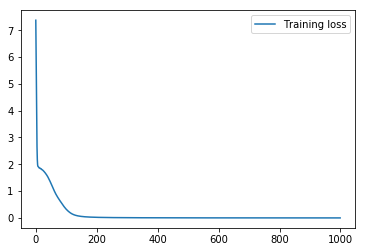

In [0]:
train_params = {
    'train_loader': train_loader,
    'val_loader': train_loader,
    'optim': torch.optim.Adam(testmodel.parameters(), lr=1e-2),
    'loss_fn': torch.nn.CrossEntropyLoss(),
    'num_epochs': 1000
}
train(testmodel, **train_params)

In [0]:
## Testing Krumhansl

In [0]:
folder = "datasets/lmd_full/0/"
#files[:5]

files = [file for file in os.listdir(folder) if '.mid' in file]
pm = pretty_midi.PrettyMIDI(folder + files[2])
pch = pm.get_pitch_class_histogram()

np.argmax(ks_key(pch)[1])

pm.key_signature_changes

folder = "datasets/Piano-midi.de/train/" #0.75 ohne C mit rel
folder = "datasets/kpcorpus/" 
folder = "datasets/lmd_full/2/"
t = time.time()

# find keys
files = [file for file in os.listdir(folder) if '.mid' in file]
    
def key(key_number):
    return pretty_midi.key_number_to_key_name(key_number)

def keynr(key):
    return pretty_midi.key_name_to_key_number(key)
       
def isFifth(realkey,predkey):
    return (realkey - predkey)%12 == 7 or (predkey - realkey)%12 == 7
        
def isRelative(realkey,predkey):
    if realkey > 11 and (realkey - 9) % 12 == predkey:
        return True
    elif predkey > 11 and (predkey - 9) % 12 == realkey:
        return True
    else:
        return False
        
def isParallel(realkey,predkey):
    return realkey%12 == predkey%12

correct ,fifth,relative,parallel,total = 0,0,0,0,0
keys=[]
print("Scale by first keychange event, \t Scale by KrumhanslSchmuckler, \t, Filename")
for i, file in enumerate(files[:100]):
    try:
        pm = pretty_midi.PrettyMIDI(folder + file)
    except:
        continue

    pm = pretty_midi.PrettyMIDI(folder + file)
    if pm.key_signature_changes != []:
        try:
            algkey = ks_key(pm.get_pitch_class_histogram(), 'aarden')
            pmkeys = [x.key_number for x in pm.key_signature_changes]
            pmkey = pmkeys[0]
            if pmkey == 0:
                continue
            keys.append([pmkey,algkey])
            #print(key(pmkey), '\t', key(int(algkey)), '\t', file, '\t', pmkeys)
        except:
            pass

correct ,fifth,relative,parallel,total = 0,0,0,0,0
for key in keys:
    realkey = key[0]
    predkey = key[1]
    total += 1
    if realkey == predkey:
        correct += 1
    elif isFifth(realkey,predkey):
        fifth += 1
    elif isRelative(realkey,predkey):
        relative += 1
    elif isParallel(realkey,predkey):
        parallel += 1
print("time", np.round(time.time()-t,2), "s")
print(correct, relative, fifth, parallel, total)
print((correct+relative)/total, correct/total, relative/total, fifth/total, parallel/total, (total-correct-fifth-relative-parallel)/total)
